In [10]:
from cmath import log
import pandas as pd
import numpy as np
import scipy.stats as stats 
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import EfficientCVaR
from pypfopt import EfficientCDaR
import copy
from pypfopt import plotting
import yfinance as yf

----------------------------------------------- Portfolio optimization -----------------------
Your portfolio is:  ['BTC-USD', 'ETH-USD', 'SUSA']
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
BTC-USD    0.293145
ETH-USD    0.382787
SUSA       0.098203
dtype: float64
          BTC-USD   ETH-USD      SUSA
BTC-USD  0.542850  0.530366  0.040999
ETH-USD  0.530366  0.908851  0.056452
SUSA     0.040999  0.056452  0.045317
-------------------------------------- Maximum sharpe ratio portfolio --------------------
The max sharpe ratio weights are: BTC-USD    0.12873
ETH-USD    0.11263
SUSA       0.75864
dtype: float64
Expected annual return: 15.5%
Annual volatility: 28.2%
Sharpe Ratio: 0.48
The performance of the max sharpe ratio portfolio is: (0.15535113391643235, 0.2822085982705309, 0.4796137847886619)
---------------------------------

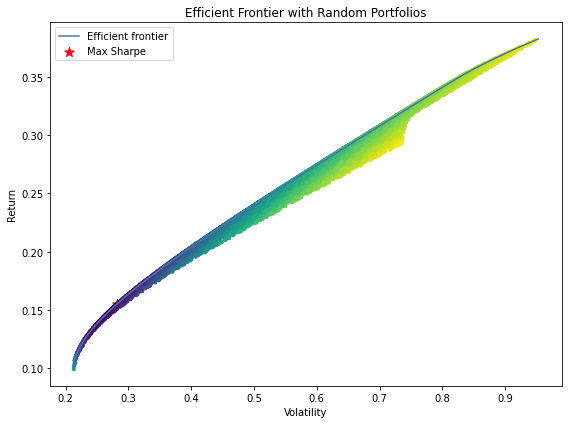

In [11]:
print('----------------------------------------------- Portfolio optimization -----------------------')

assets = []

x = int(input('Insert number of assets in the portfolio: '))

for i in range(x):
    n = str(input(f'Asset nº {i}: '))
    assets.append(n)

print("Your portfolio is: ", assets)

df = {}
for i in assets:
    df_temp = yf.download(i).reset_index()
    df[i] = df_temp[df_temp.Date>'2017-11-10'][['Date','Close']].rename(columns={'Close':i}).set_index('Date')
df_final = pd.concat([v for k,v in df.items()],axis=1).dropna()

mu = expected_returns.mean_historical_return(df_final)
S = risk_models.sample_cov(df_final)
print(mu)
print(S)

print('-------------------------------------- Maximum sharpe ratio portfolio --------------------')
ef_maxsharp = EfficientFrontier(mu, S)
raw_weights_maxsharp = ef_maxsharp.max_sharpe()
clean_weights = ef_maxsharp.clean_weights()
w_maxsharp = pd.Series(ef_maxsharp.clean_weights())
print('The max sharpe ratio weights are:', w_maxsharp)
print('The performance of the max sharpe ratio portfolio is:', ef_maxsharp.portfolio_performance(verbose=True))


print('----------------------------------- Minimum CVAR model ---------------------------------')
new_returns = expected_returns.returns_from_prices(df_final).dropna()
ec_cvar = EfficientCVaR(mu, new_returns)
print('The min CVAR weights are:', ec_cvar.min_cvar())
print('The performance of the min CVAR portfolio is:', ec_cvar.portfolio_performance(verbose=True))


print('----------------------------------- Minimum CDaR model ---------------------------------')
ec_cdar = EfficientCDaR(mu, new_returns)
print('The min CVAR weights are:', ec_cdar.min_cdar())
#cdar_weighs_raw = ec_cdar.min_cdar()
#cdar_weighs = ec_cdar.clean_weights()
#w_cdar = pd.Series(cvar_weighs)
print('The performance of the min CVAR portfolio is:', ec_cdar.portfolio_performance(verbose=True))



def plot_efficient_frontier_and_max_sharpe(mu, S):  
    # Optimize portfolio for maximal Sharpe ratio 
    ef = EfficientFrontier(mu, S)

    fig, ax = plt.subplots(figsize=(8,6))
    ef_max_sharpe = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

    # Find the max sharpe portfolio
    ef_max_sharpe.max_sharpe(risk_free_rate=0.02)
    ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

    # Generate random portfolios
    n_samples = 10000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    # Output
    ax.set_title("Efficient Frontier with Random Portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_efficient_frontier_and_max_sharpe(mu, S)
